# WUM 2020: Projekt II, Milestone III

## Jakub Kosterna, Zuzanna Mróz & Aleksander Podsiad

<h1 id="tocheading">Spis treści</h1>
<div id="toc"></div>

## Odczyt dotychczasowej roboty i koncepcja

### Odświeżenie tematu i cel

Podczas pracy w ciągu ostatnich tygodni przyjrzeliśmy się interesującej ramce danych *online shoppers intention* i dokonaliśmy wstępnego modelowania korzystając z trzech implementacji metod uczenia nienadzorowanego. Czy korzystając z poznanych algorytmów klasteryzacji uda nam się sensownie podzielić klientów sklepu internetowego na jakieś grupy? W niniejszym raporcie:

1. Utworzymy jeszcze trzy dodatkowe ramki, w których dokonamy różnych metod przygotowania danych pod klasteryzację
2. Znajdziemy optymalne liczby podziałów dla czterech analizowanych frames
3. Dokonamy ostatecznego modelowania na kilku nowych datasetach przygotowanych pod uczenie nienadzorowane
4. Przyjrzymy się ważności zmiennych wspomnianych datasetów w temacie analizy składowych głównych PCA
5. Zwizualizujemy podziały PCA i tSNE
6. Porównamy wyniki między obserwacjami w poszczególnych klastrach, jakie dadzą nam algorytmy
7. Zadecydujemy, który z czterech datasetów zawierających informacje o klientach sklepu internetowego okazał się być najlepszy pod znajdowanie grup pośród nich

Należy więc podkreślić, że koniec końców nie zdecydowaliśmy się na typową ocenę różnych algorytmów klasteryzacji i sprawdzenie, które radzą sobie lepiej, a które gorzej na naszej ramce danych, lecz **skoncentrowaliśmy się nad porównaniem różnych koncepcji przygotowania ramki danych pod klasteryzację**. *Online shoppers intention* to w końcu zdecydowanie godny uwagi zbiór zawierający dane przeróżnego typu i naprawdę jest co badać.

W celu dalszej zabawy wczytajmy potrzebne pakiety.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import random
import warnings
import copy
import math

from mpl_toolkits import mplot3d
%matplotlib inline

from sklearn.cluster import MiniBatchKMeans
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

np.random.seed(0)

### Algorytm uczenia nienadzorowanego

W ramach pracy nad zbiorem zakupów internetowych ostatnim razem uruchomiliśmy kilka algorytmów klasteryzacji, między innymi *DBSCAN* i *GMM*. Biorąc pod uwagę jednak złożony problem i już wiele elementów, które chcemy zanalizować i wyciągnąć prawdopodobnie wartościowe wnioski zdecydowaliśmy się na tylko jeden - **KMeans** z pakietu *sklearn*. Dobrze dodatkowo zauważyć, że już ostatnio owa metoda wypadła dosyć dobrze i dane dobrze do niej pasują - mierzenie odległości między obserwacjami na płaszczyźnie kilkudziesięciowymiarowej wydaje się być w naszym przypadku jak najbardziej naturalne.

Do znalezienia najlepszej liczby klastrów dla wspomnianych ramek i porównania podziałów między nimi posłużymy się metodą Silhouette.

### Ramki danych do klasteryzacji

Oprócz oryginalnego datasetu, który pobraliśmy z przygotowanego repozytorium (plik *online_shoppers_intention.csv*) i data frame powstałej w KM2, postanowiliśmy postawić jeszcze na trzy inne. Podsumowując, będziemy operować na pięciu formach zbioru:

* **df1** - dane nieobrobione
* **df2** - mocno podrasowany dataset utworzony na potrzeby ostatniego milestone
* **df3** - usprawniona tabela oryginalna rezygnująca z dodatkowych miar jak w *df2*, za to z typowym one-hot encodingiem zmiennych kategorycznych i normalizacją, a dodatkowo **radząca sobie z miesiącami z pomocą współrzędnych kołowych**
* **df4** - zagubione ogniwo między *df2* i *df3* - zachowane właściwości *df2*, ale z "miesiącami kołowymi" z opcji wyżej
* **df5** - *df4*, ale z mądrzejszą koncepcją one-hot encodingu zmiennych kategorycznych - o niej w rozdziale jej poświęconym

### Wczytanie wcześniej utworzonych datasetów

Wpierw wczytajmy dwie ramki danych - oryginalną [*pd1*] i tą przygotowaną na ostatnim kamieniu milowym [*pd2*]. W celu odczytu tej drugiej lekko zmodyfikowaliśmy skrypt z drugiego kamienia milowego, żeby wyeksportować nasze dzieło.

In [2]:
df1 = pd.read_csv("online_shoppers_intention.csv")
df2 = pd.read_csv("shoppers_km2.csv")
df2 = df2.iloc[:,1:66]
warnings.simplefilter('ignore')

## Przygotowanie dodatkowych frames

### Utworzenie *df3*

Pierwszą ramką, którą postanowiliśmy przygotować w ramach tej pracy będzie ulepszona wersja formy, będzie nieco prostsza i bardziej podstawowa obróbka surowych danych niż metodyka, którą zastosowaliśmy dwa tygodnie temu. W tym wypadku operacje, których dokonamy to:
    
1. Kolumnę *Month* przekonwertujemy do dwóch kolumn powstałych przez reprezentację 12 miesięcy jako punkty na kole - stąd dwa wymiary
2. Klasyczne zastosowanie *One-hot encoder* na zmiennych kategorycznych bez udziwnień
3. Typowa normalizacja, bez kombinowania z percentylami, standaryzacją i innymi bajerami jak w KM2

In [3]:
df3 = copy.deepcopy(df1)

months = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'June', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
pi = math.pi

df3[['MonthSin']] = df3[['Month']]
df3[['MonthCos']] = df3[['Month']]

for i in range(len(months)):
    df3[['MonthSin']] = df3[['MonthSin']].replace(months[i], math.sin(2*pi/(i+1)))
    df3[['MonthCos']] = df3[['MonthCos']].replace(months[i], math.cos(2*pi/(i+1)))
    
df3 = df3.drop('Month', axis = 1)

df3.loc[(df3['VisitorType']=='New_Visitor'), 'VisitorType0'] = 1
df3.loc[(df3['VisitorType']=='New_Visitor'), 'VisitorType1'] = 0
df3.loc[(df3['VisitorType']=='Returning_Visitor'), 'VisitorType0'] = 0
df3.loc[(df3['VisitorType']=='Returning_Visitor'), 'VisitorType1'] = 1
df3.loc[(df3['VisitorType']=='Other'), 'VisitorType0'] = 0
df3.loc[(df3['VisitorType']=='Other'), 'VisitorType1'] = 0

df3 = df3.drop('VisitorType', axis = 1)

df3.loc[(df3['Weekend']==False), 'Weekend'] = 0
df3.loc[(df3['Weekend']==True), 'Weekend'] = 1
df3.loc[(df3['Revenue']==False), 'Revenue'] = 0
df3.loc[(df3['Revenue']==True), 'Revenue'] = 1

df3['VisitorType0'] = df3['VisitorType0'].astype(object)
df3['VisitorType1'] = df3['VisitorType1'].astype(object)
df3['Revenue'] = df3['Revenue'].astype(object)
df3['Weekend'] = df3['Weekend'].astype(object)

oper = np.array(df1[["OperatingSystems"]])
brow = np.array(df1[["Browser"]])
reg = np.array(df1[["Region"]])
traf = np.array(df1[["TrafficType"]])

from sklearn.preprocessing import LabelEncoder

leOper = LabelEncoder()
leBrow = LabelEncoder()
leReg = LabelEncoder()
leTraf = LabelEncoder()
operIntEnc = leOper.fit_transform(oper)
browIntEnc = leBrow.fit_transform(brow)
regIntEnc = leReg.fit_transform(reg)
trafIntEnc = leTraf.fit_transform(traf)

from sklearn.preprocessing import OneHotEncoder

operOnehotEncoder = OneHotEncoder(sparse=False)
browOnehotEncoder = OneHotEncoder(sparse=False)
regOnehotEncoder = OneHotEncoder(sparse=False)
trafOnehotEncoder = OneHotEncoder(sparse=False)

operIntEnc = operIntEnc.reshape(len(operIntEnc), 1)
browIntEnc = browIntEnc.reshape(len(browIntEnc), 1)
regIntEnc = regIntEnc.reshape(len(regIntEnc), 1)
trafIntEnc = trafIntEnc.reshape(len(trafIntEnc), 1)

operOnehotEncoded = operOnehotEncoder.fit_transform(operIntEnc)
browOnehotEncoded = browOnehotEncoder.fit_transform(browIntEnc)
regOnehotEncoded = regOnehotEncoder.fit_transform(regIntEnc)
trafOnehotEncoded = trafOnehotEncoder.fit_transform(trafIntEnc)

dfOperOnehot = pd.DataFrame(operOnehotEncoded)
dfBrowOnehot = pd.DataFrame(browOnehotEncoded)
dfRegOnehot = pd.DataFrame(regOnehotEncoded)
dfTrafOnehot = pd.DataFrame(trafOnehotEncoded)

dfOperOnehot.columns = ['OperatingSystems' + str(col) for col in pd.DataFrame(operOnehotEncoded).columns]
dfBrowOnehot.columns = ['Browser' + str(col) for col in pd.DataFrame(browOnehotEncoded).columns]
dfRegOnehot.columns = ['Region' + str(col) for col in pd.DataFrame(regOnehotEncoded).columns]
dfTrafOnehot.columns = ['TrafficType' + str(col) for col in pd.DataFrame(trafOnehotEncoded).columns]

df3 = pd.concat([df3, dfOperOnehot, dfBrowOnehot, dfRegOnehot, dfTrafOnehot], axis = 1)
df3 = df3.drop(['OperatingSystems', 'Browser', 'Region', 'TrafficType'], axis = 1)

df3=(df3-df3.min())/(df3.max()-df3.min())

In [4]:
df3.shape

(12330, 66)

Także i w tym wypadku przyjrzymy się podziałowi na dwa klastry.

### Utworzenie *df4*

Tutaj ramka zasugerowana na omówieniu ostatniego kamienia milowego - upiękniony dataset idąc algorytmem sprzed dwóch tygodni... ale dodatkowo z mądrym patentem współrzędnych kołowych!

In [5]:
df4 = copy.deepcopy(df2)

months = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'June', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
pi = math.pi

df4[['MonthSin']] = df4[['Month']]
df4[['MonthCos']] = df4[['Month']]

for i in range(len(months)):
    df4[['MonthSin']] = df4[['MonthSin']].replace(months[i], 2*math.sin(pi/(i+1)))
    df4[['MonthCos']] = df4[['MonthCos']].replace(months[i], 2*math.cos(pi/(i+1)))
    
df4 = df4.drop('Month', axis = 1)

### Utworzenie *df5*

Dla *df2* one-hot encoding jest nieco - umówmy się - losowy. Stała 0.3, bo... tak?

Okey, ale co gdyby tak postawić na lepszą alternatywę: każdej wartości powstałej z one-hot encodingu zamiast stałej 0.3 przyznamy nie tą randomową stałą niezależnie od zmiennej - lecz wartość **2 / <liczba unikalnych wartości danej kolumny>**. Dzięki tej mądrej idei automatycznie feautures posiadające mniej wymiarów, będą wykazywały większe różnienie się między sobą i będą bardziej zbliżone do typowego one-hot encodingu. Warto zauważyć, że idea ta jest o tyle mądra, że zmniejsza sztuczną ważność cech, które oryginalnie dotyczyły tylko jednej kolumny mając wiele różnych wartości, a koniec końców zajmują dużą część wszystkich słupów przy mniejszym wpływie na klasteryzację. 

In [6]:
cat_counts = df1[['OperatingSystems', 'Browser', 'Region', 'TrafficType']].nunique()
cat_counts

OperatingSystems     8
Browser             13
Region               9
TrafficType         20
dtype: int64

In [7]:
firOpeColID = 14
firBroColID = firOpeColID + cat_counts['OperatingSystems']
firRegColID = firBroColID + cat_counts['Browser']
firTraColID = firRegColID + cat_counts['Region']

In [8]:
df5 = copy.deepcopy(df4)

df5.iloc[:,firOpeColID:firBroColID] = df5.iloc[:,firOpeColID:firBroColID].replace(0.3, 2 / cat_counts['OperatingSystems'])
df5.iloc[:,firBroColID:firRegColID] = df5.iloc[:,firBroColID:firRegColID].replace(0.3, 2 / cat_counts['Browser'])
df5.iloc[:,firRegColID:firTraColID] = df5.iloc[:,firRegColID:firTraColID].replace(0.3, 2 / cat_counts['Region'])
df5.iloc[:,firTraColID:(firTraColID+cat_counts['TrafficType'])] = df5.iloc[:,firRegColID:(firTraColID+cat_counts['TrafficType'])].replace(0.3, 2 / cat_counts['TrafficType'])

df5.sample(10)

InformationalDurRate  BounceRates  ExitRates  PageValues  SpecialDay  \
12245                   0.0     0.047297   0.214296    0.000000         0.0   
9704                    1.0     0.039683   0.134041    0.000000         0.0   
9177                    0.0     0.051477   0.095544    0.000000         0.0   
8848                    0.0     1.000000   1.000000    0.000000         0.0   
2768                    0.0     1.000000   1.000000    0.000000         1.0   
11549                   1.0     0.021580   0.078678    0.003501         0.0   
2193                    0.5     0.020000   0.020000    0.040889         0.0   
7772                    0.0     0.000000   0.021825    0.058785         0.0   
6338                    0.0     0.025000   0.139583    0.001991         0.0   
4008                    0.0     0.000000   0.500000    0.000000         0.6   

       Weekend  Revenue  AdministrativeResMan  InformationalResMan  \
12245      0.0      0.0                   0.0                  0.0   
9704       0.0      0.0                   0.8                  0.2   
9177       1.0      0.0                   0.4                  0.0   
8848       0.0      0.0                   0.0                  0.0   
2768       1.0      0.0                   0.0                  0.0   
11549      0.0      1.0                   0.2                  0.4   
2193       0.0      0.0                   0.2                  0.2   
7772       0.0      0.0                   0.0                  0.0   
6338       0.0      1.0                   0.0                  0.0   
4008       0.0      0.0                   0.0                  0.0   

       ProductRelatedResMan  ...  TrafficType12  TrafficType13  TrafficType14  \
12245                   0.8  ...            0.0            0.0            0.0   
9704                    1.0  ...            0.0            0.0            0.0   
9177                    0.8  ...            0.0            0.0            0.0   
8848                    0.2  ...            0.0            0.0            0.0   
2768                    0.2  ...            0.0            0.0            0.0   
11549                   1.0  ...            0.0            0.0            0.0   
2193                    0.6  ...            0.0            0.0            0.0   
7772                    0.6  ...            0.0            0.0            0.0   
6338                    0.8  ...            0.0            0.0            0.0   
4008                    0.2  ...            0.0            0.0            0.0   

       TrafficType15  TrafficType16  TrafficType17  TrafficType18  \
12245            0.0            0.0            0.0            0.0   
9704             0.0            0.0            0.0            0.0   
9177             0.0            0.0            0.0            0.0   
8848             0.0            0.0            0.0            0.0   
2768             0.0            0.0            0.0            0.0   
11549            0.0            0.0            0.0            0.0   
2193             0.0            0.0            0.0            0.0   
7772             0.0            0.0            0.0            0.0   
6338             0.0            0.0            0.0            0.0   
4008             0.0            0.0            0.0            0.0   

       TrafficType19  MonthSin  MonthCos  
12245            0.0       0.9       0.9  
9704             0.0       1.0       1.0  
9177             0.0       0.9       0.9  
8848             0.1       0.9       0.9  
2768             0.0       0.3       0.3  
11549            0.0       0.9       0.9  
2193             0.0       0.3       0.3  
7772             0.0       0.7       0.7  
6338             0.0       0.7       0.7  
4008             0.0       0.3       0.3  

[10 rows x 66 columns]

In [9]:
df5['Region0'].sample(10)

12300    0.000000
2866     0.000000
12319    0.222222
4013     0.222222
7807     0.222222
439      0.000000
9994     0.222222
11111    0.222222
11357    0.000000
8319     0.000000
Name: Region0, dtype: float64

Sukces!

## Najlepsze liczby klastrów według *silhouette score*

Dla każdej z czterech ramek sprawdzimy, jakie sugestie otrzymamy od wspomnianego współczynnika dla liczby podziałów od 2 do 30.

### Szukanie optymalnego n dla *df2*

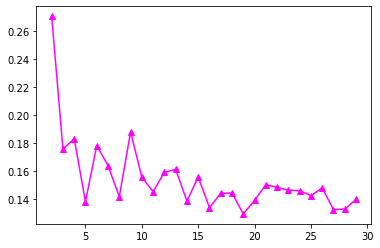

In [10]:
n = []
score = []

for n_clusters in range(2,30):
    clusterer = MiniBatchKMeans(n_clusters, random_state = 0)
    preds = clusterer.fit_predict(df2)
    n.append(n_clusters)
    score.append(silhouette_score(df2, preds))
    
plt.plot(n,score,'^-', color="fuchsia")

In [11]:
mbKmeans = MiniBatchKMeans(n_clusters=2, random_state=0)
mbKmeans.fit(df2)
pred = mbKmeans.predict(df2)
ss2 = silhouette_score(df2, pred)
ss2

0.27083624115936916

Patrząc na wyniki przynajmniej *df2* - dwa klastry, zdecydowanie.

### Szukanie optymalnego n dla *df3*

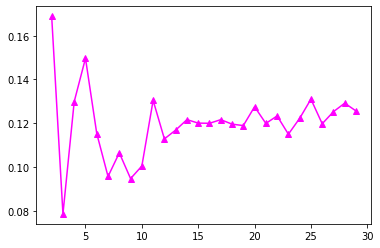

In [12]:
n = []
score = []

for n_clusters in range(2,30):
    clusterer = MiniBatchKMeans(n_clusters, random_state = 0)
    preds = clusterer.fit_predict(df3)
    n.append(n_clusters)
    score.append(silhouette_score(df3, preds))
    
plt.plot(n,score,'^-', color="fuchsia")

In [13]:
kmeans = MiniBatchKMeans(n_clusters=2, random_state=0)
kmeans.fit(df3)
pred = kmeans.predict(df3)
ss3 = silhouette_score(df3, pred)
ss3

0.16890692495716353

W tym wypadku *silhouette score* wypadł nieco gorzej niż dla *df2*, ale wciąż jest w miarę satysfakcjonujący - i co najważniejsze dodatni oraz większy od wszystkich innych typów między 3 a 30!

### Szukanie optymalnego n dla *df4*

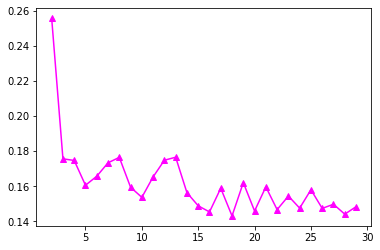

In [14]:
n = []
score = []

for n_clusters in range(2,30):
    clusterer = MiniBatchKMeans(n_clusters, random_state = 0)
    preds = clusterer.fit_predict(df4)
    n.append(n_clusters)
    score.append(silhouette_score(df4, preds))
    
plt.plot(n,score,'^-', color="fuchsia")

In [15]:
kmeans = MiniBatchKMeans(n_clusters=2, random_state=0)
kmeans.fit(df4)
pred = kmeans.predict(df4)
ss4 = silhouette_score(df4, pred)
ss4

0.2558625284642099

Tutaj dwa klastry wybijają się podobnie mocno jak dla *df2* - właściwie bez zaskoczeń, bo diametralnie dużo się nie zmieniło.

Tylko... wynik *silhouette* nawet nieco niższy? Zaskakujące i nieoczekiwane.

### Szukanie optymalnego n dla *df5*

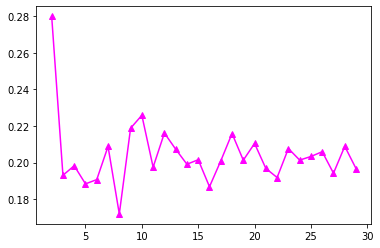

In [16]:
n = []
score = []

for n_clusters in range(2,30):
    clusterer = MiniBatchKMeans(n_clusters, random_state = 0)
    preds = clusterer.fit_predict(df5)
    n.append(n_clusters)
    score.append(silhouette_score(df5, preds))
    
plt.plot(n,score,'^-', color="fuchsia")

I znowu n = 2 na szczycie!

In [17]:
kmeans = MiniBatchKMeans(n_clusters=2, random_state=0)
kmeans.fit(df5)
pred = kmeans.predict(df5)
ss5 = silhouette_score(df5, pred)
ss5

0.2799141562830069

Co ciekawe - z najwyższym wynikiem *silhouette* ze wszystkich!

Ogólnie wniosek jest prosty - każdą ramkę dzielimy na dwa klastry i już, nie ma innej opcji.

## Ważność zmiennych - PCA

Abstrahując od wizualizacji, *sklearn* dla *PCA* oferuje całkiem w porządku narzędzie do feature importance. Wykorzystajmy je i porównajmy wyniki dla naszych czterech ramek!

### Feature importance *df2*

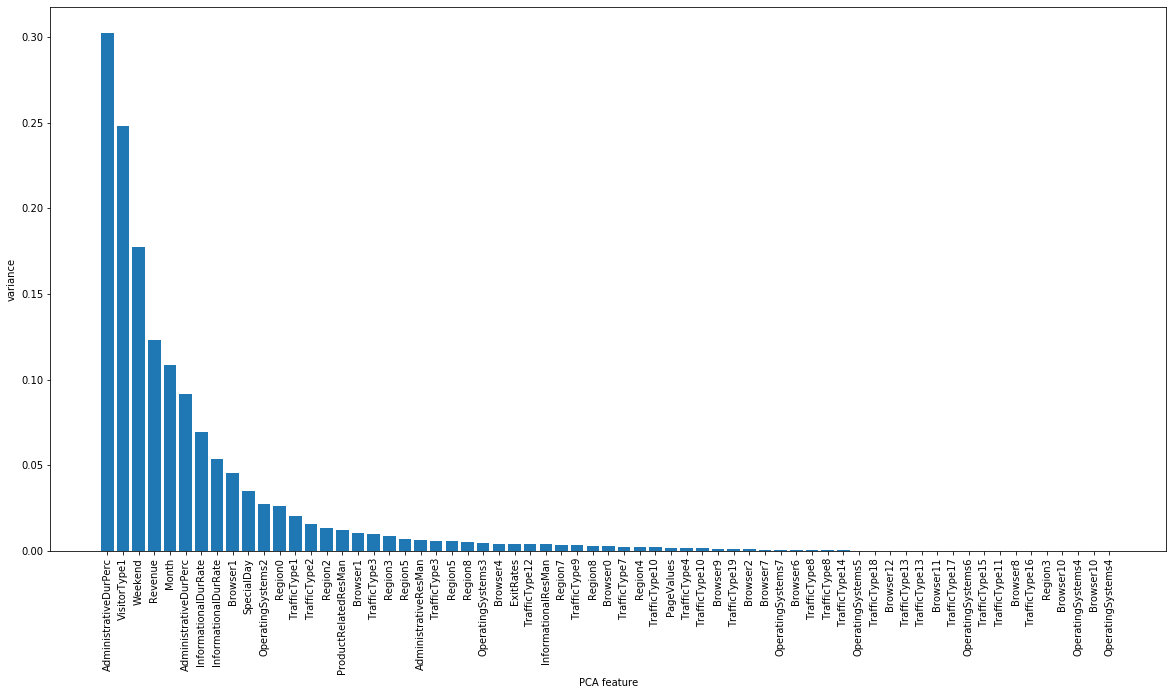

In [18]:
model = PCA().fit(df2)
X_pc_2 = model.transform(df2)

# number of components
n_pcs = model.components_.shape[0]

# get the index of the most important feature on EACH component
# LIST COMPREHENSION HERE
most_important = [np.abs(model.components_[i]).argmax() for i in range(n_pcs)]

initial_feature_names = df2.columns
# get the names
most_important_names = [initial_feature_names[most_important[i]] for i in range(n_pcs)]

# LIST COMPREHENSION HERE AGAIN
dic = {'PC{}'.format(i): most_important_names[i] for i in range(n_pcs)}

# build the dataframe
df = pd.DataFrame(dic.items())

# Plot the explained variances
plt.figure(figsize=(20,10))
features = range(model.n_components_)
names = df.iloc[:,1]
plt.bar(features, model.explained_variance_)
plt.xlabel('PCA feature')
plt.ylabel('variance')
plt.xticks(features, list(names), rotation=90)
plt.show()

Nawet zaskakujące! *Revenue* owszem, ale... akurat *Administrative duration time* przekonwertowane na percentyle, *Visitor type* mówiące o tym czy klient jest nowy czy powracający i weekend? Ciekawe!

### Feature importance *df3*

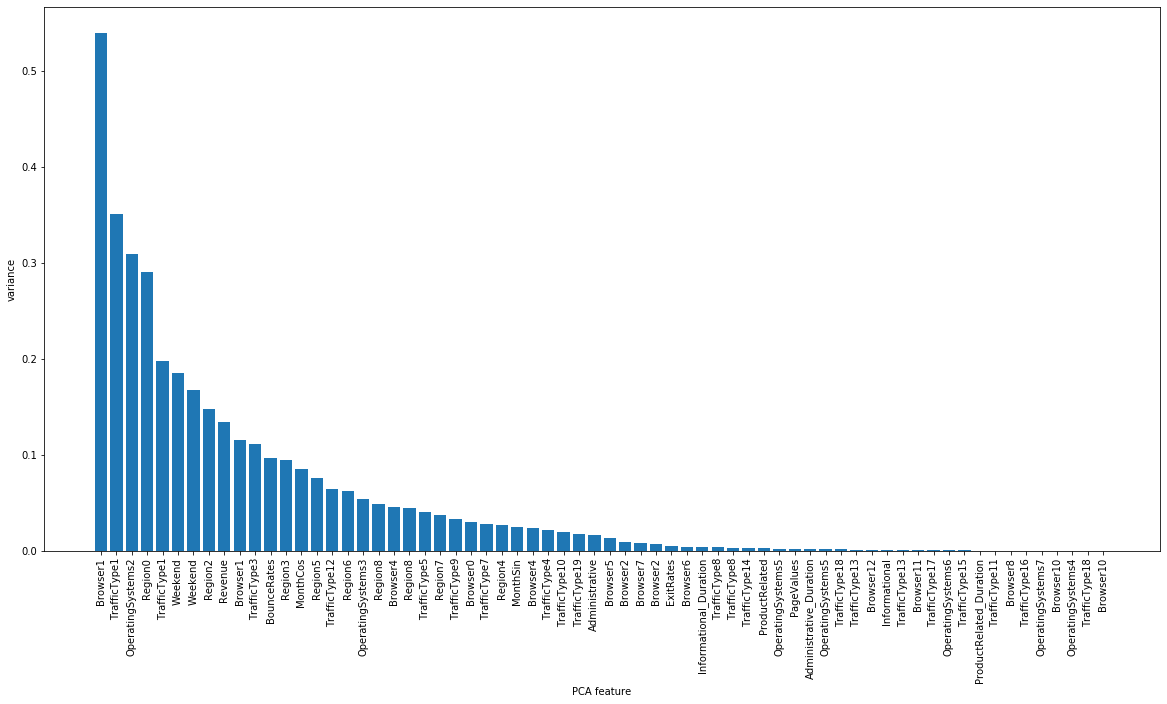

In [19]:
model = PCA().fit(df3)
X_pc_3 = model.transform(df3)

n_pcs= model.components_.shape[0]

most_important = [np.abs(model.components_[i]).argmax() for i in range(n_pcs)]

initial_feature_names = df3.columns
most_important_names = [initial_feature_names[most_important[i]] for i in range(n_pcs)]

dic = {'PC{}'.format(i): most_important_names[i] for i in range(n_pcs)}

df = pd.DataFrame(dic.items())

plt.figure(figsize=(20,10))
features = range(model.n_components_)
names = df.iloc[:,1]
plt.bar(features, model.explained_variance_)
plt.xlabel('PCA feature')
plt.ylabel('variance')
plt.xticks(features, list(names), rotation=90)
plt.show()

Widać efekty prymitywnego one-hot encodingu - tutaj na prowadzenie wysunęły się najpopularniejsze przeglądarki, typy podróży po sieci, systemy operacyjne i regiony. Przypadek? Nie sądzę!

### Feature importance *df4*

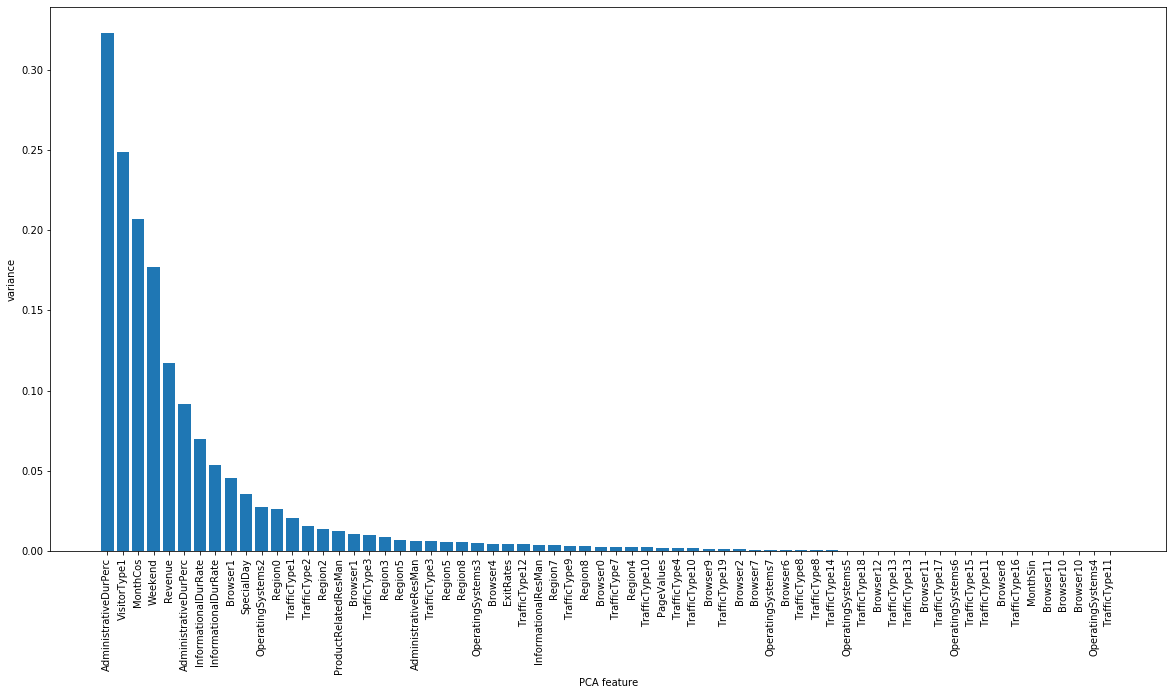

In [20]:
model = PCA().fit(df4)
X_pc_4 = model.transform(df4)

n_pcs= model.components_.shape[0]

most_important = [np.abs(model.components_[i]).argmax() for i in range(n_pcs)]

initial_feature_names = df4.columns
most_important_names = [initial_feature_names[most_important[i]] for i in range(n_pcs)]

dic = {'PC{}'.format(i): most_important_names[i] for i in range(n_pcs)}

df = pd.DataFrame(dic.items())

plt.figure(figsize=(20,10))
features = range(model.n_components_)
names = df.iloc[:,1]
plt.bar(features, model.explained_variance_)
plt.xlabel('PCA feature')
plt.ylabel('variance')
plt.xticks(features, list(names), rotation=90)
plt.show()

W gruncie rzeczy bardzo podobny podział do *df2* - bez zaskoczeń, bo jakby nie patrzeć - są bardzo podobne.

### Feature importance *df5*

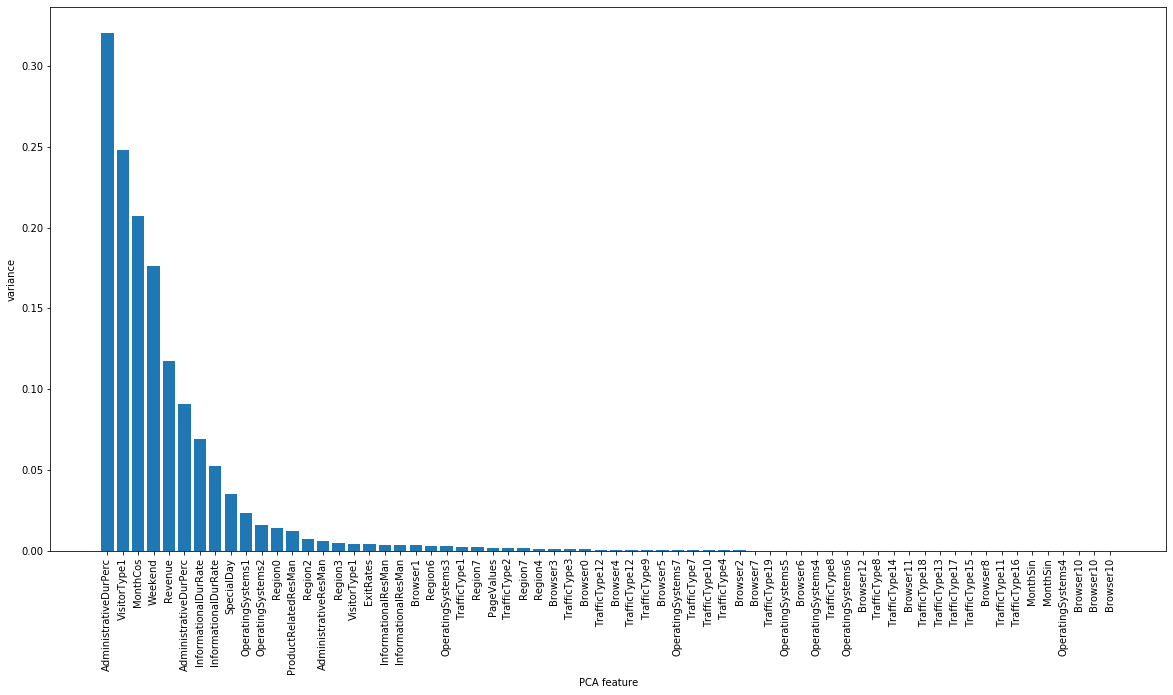

In [21]:
model = PCA().fit(df5)
X_pc_5 = model.transform(df5)

n_pcs= model.components_.shape[0]

most_important = [np.abs(model.components_[i]).argmax() for i in range(n_pcs)]

initial_feature_names = df4.columns
most_important_names = [initial_feature_names[most_important[i]] for i in range(n_pcs)]

dic = {'PC{}'.format(i): most_important_names[i] for i in range(n_pcs)}

df = pd.DataFrame(dic.items())

plt.figure(figsize=(20,10))
features = range(model.n_components_)
names = df.iloc[:,1]
plt.bar(features, model.explained_variance_)
plt.xlabel('PCA feature')
plt.ylabel('variance')
plt.xticks(features, list(names), rotation=90)
plt.show()

I znowu efekt podobny do *df2*, a zarazem *df4*, ale co satysfakcjonujące - można zaobserwować o wiele lepszy bilans między kolumnami odpowiadającymi za kolumny utworzone przez one-hot encoding dostosowany do zróżnicowania feautures.

## Wykresy PCA

... czyli to, na co chyba wszyscy czekaliśmy! Zobaczymy dwie wersje wygenerowanych sztucznych podziałów na zredukowanych wymiarach - na płaszczyźnie i w 3D.

### Wizualizacje *df2*

In [22]:
pca1 = X_pc_2[:,0]
pca2 = X_pc_2[:,1]
pca3 = X_pc_2[:,2]

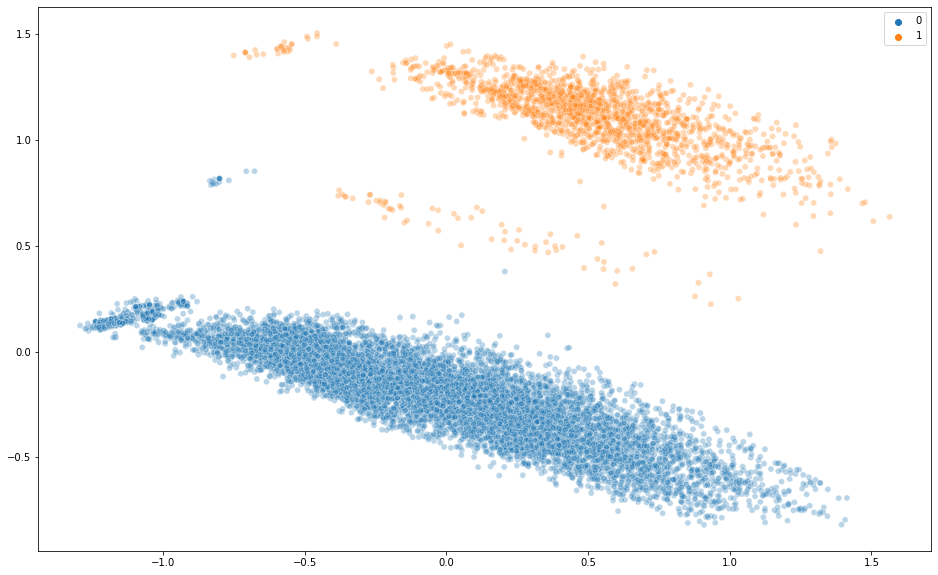

In [23]:
plt.figure(figsize=(16,10))
sns.scatterplot(
    x=pca1, y=pca2,
    hue=pred,
    legend="full",
    alpha=0.3)

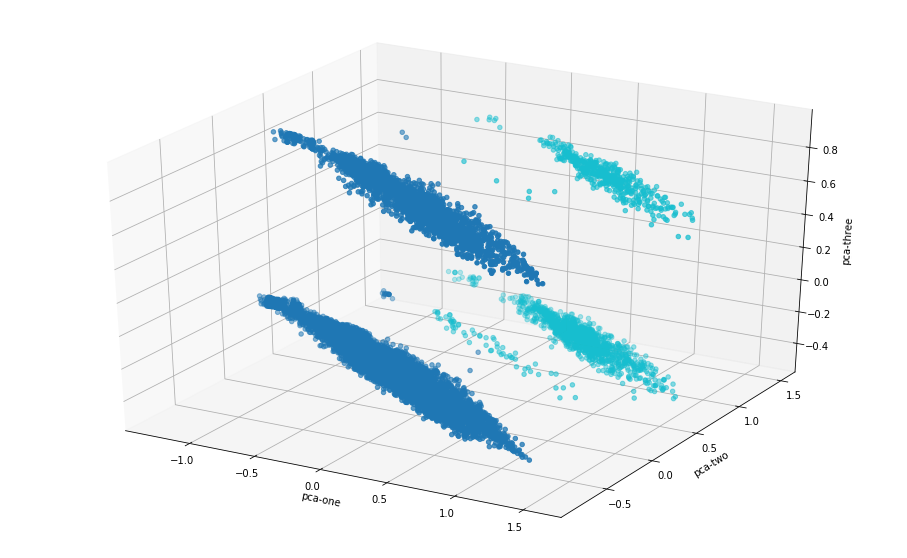

In [24]:
ax = plt.figure(figsize=(16,10)).gca(projection='3d')
ax.scatter(
    xs=pca1, 
    ys=pca2, 
    zs=pca3, 
    c=pred,
    cmap='tab10'
)
ax.set_xlabel('pca-one')
ax.set_ylabel('pca-two')
ax.set_zlabel('pca-three')
plt.show()

Interesujące! Mimo dwóch klastrów, w trzech wymiarach możemy zaobserwować właściwie cztery główne skupiska. Dla 2D - już normalnie.

### Wizualizacje *df3*

In [25]:
pca1 = X_pc_3[:,0]
pca2 = X_pc_3[:,1]
pca3 = X_pc_3[:,2]

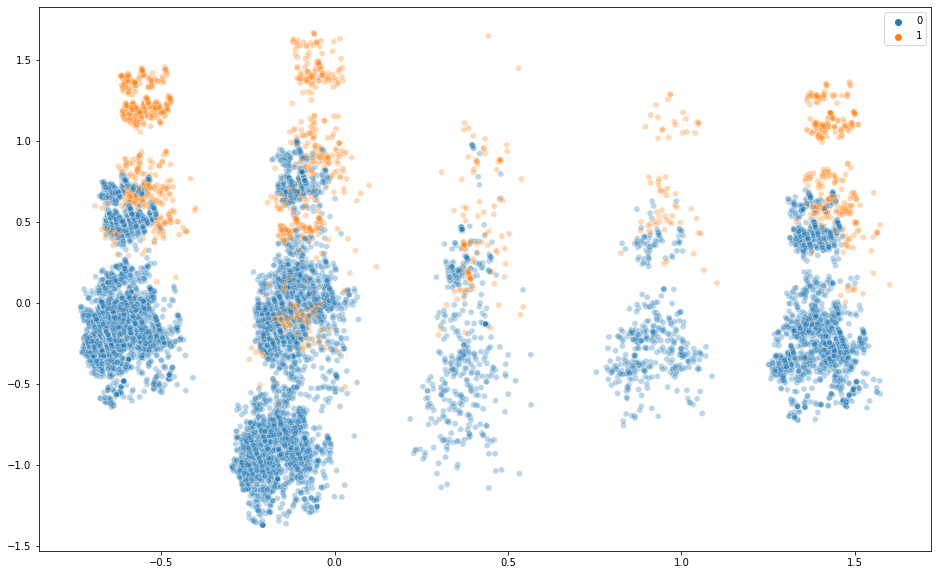

In [26]:
plt.figure(figsize=(16,10))
sns.scatterplot(
    x=pca1, y=pca2,
    hue=pred,
    legend="full",
    alpha=0.3)

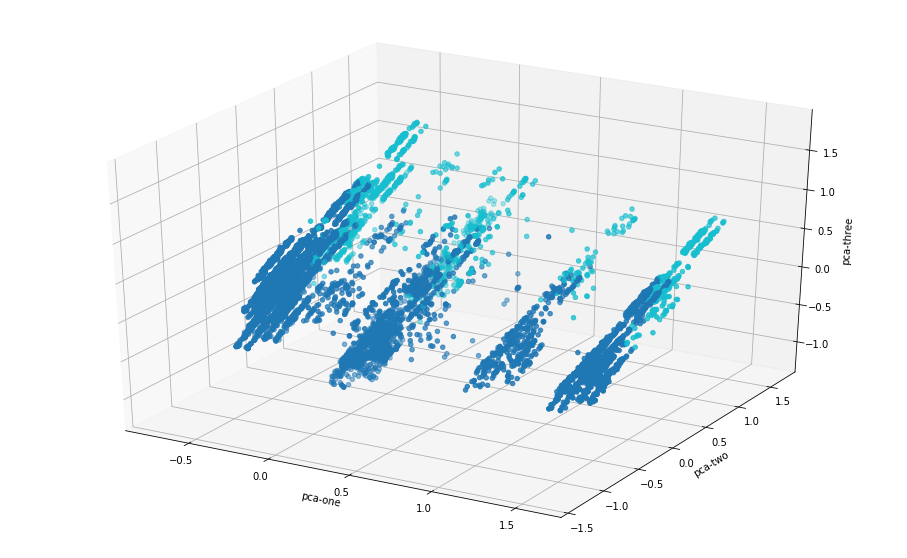

In [27]:
ax = plt.figure(figsize=(16,10)).gca(projection='3d')
ax.scatter(
    xs=pca1, 
    ys=pca2, 
    zs=pca3, 
    c=pred,
    cmap='tab10'
)
ax.set_xlabel('pca-one')
ax.set_ylabel('pca-two')
ax.set_zlabel('pca-three')
plt.show()

Auć! Dobrze było zrobić niestandardowy one-hot encoding dla pozostałych trzech frames.

### Wizualizacje *df4*

In [28]:
pca1 = X_pc_4[:,0]
pca2 = X_pc_4[:,1]
pca3 = X_pc_4[:,2]

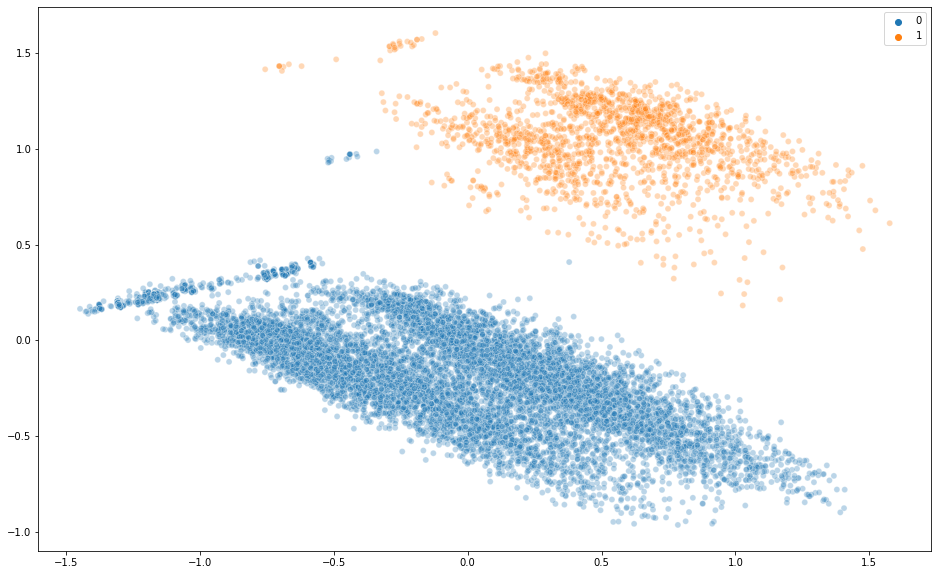

In [29]:
plt.figure(figsize=(16,10))
sns.scatterplot(
    x=pca1, y=pca2,
    hue=pred,
    legend="full",
    alpha=0.3)

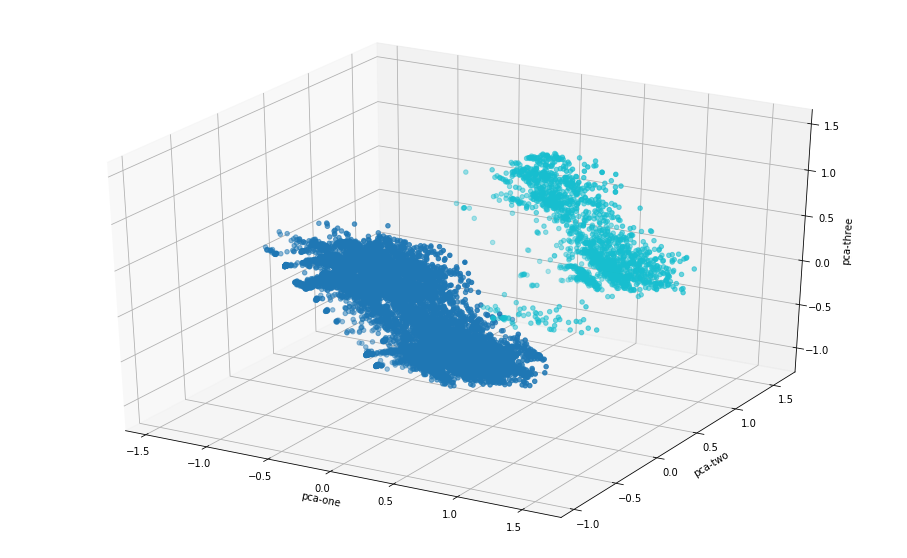

In [30]:
ax = plt.figure(figsize=(16,10)).gca(projection='3d')
ax.scatter(
    xs=pca1, 
    ys=pca2, 
    zs=pca3, 
    c=pred,
    cmap='tab10'
)
ax.set_xlabel('pca-one')
ax.set_ylabel('pca-two')
ax.set_zlabel('pca-three')
plt.show()

Niesamowite! A tutaj cztery skupiska już zacierają się w dwa. Czyżby *df4* przeważało nad *df2* i *df3*? Zobaczmy jeszcze *df5*!

### Wizualizacje *df5*

In [31]:
pca1 = X_pc_5[:,0]
pca2 = X_pc_5[:,1]
pca3 = X_pc_5[:,2]

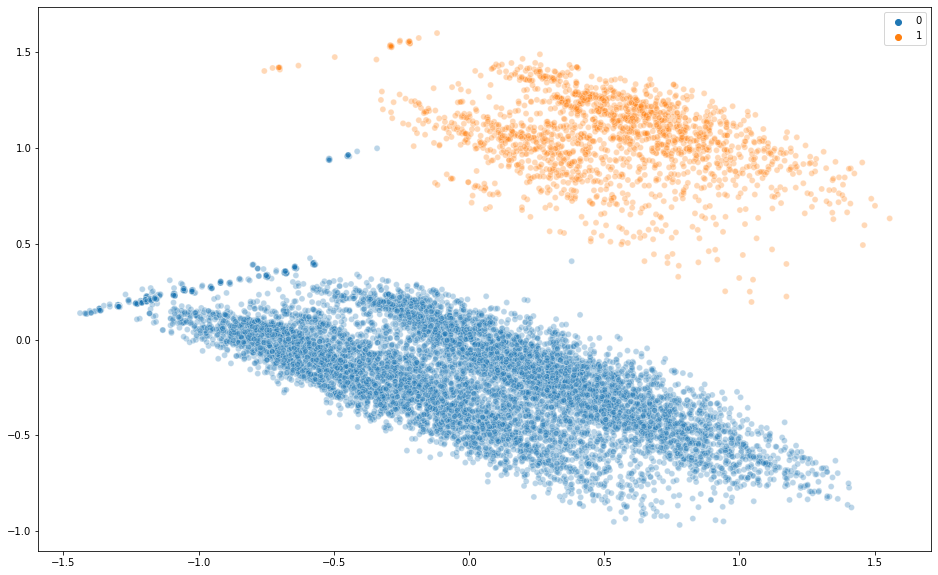

In [32]:
plt.figure(figsize=(16,10))
sns.scatterplot(
    x=pca1, y=pca2,
    hue=pred,
    legend="full",
    alpha=0.3)

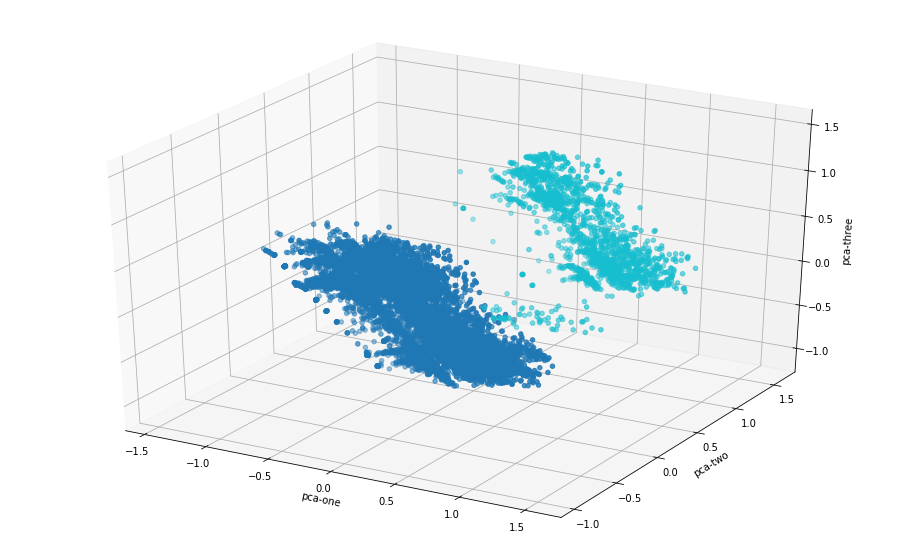

In [33]:
ax = plt.figure(figsize=(16,10)).gca(projection='3d')
ax.scatter(
    xs=pca1, 
    ys=pca2, 
    zs=pca3, 
    c=pred,
    cmap='tab10'
)
ax.set_xlabel('pca-one')
ax.set_ylabel('pca-two')
ax.set_zlabel('pca-three')
plt.show()

Mimo nieco wyższego silhouette score dla *df5* niż *df4*, wynik PCA jest już niemalże taki sam.

## Wykresy tSNE

.. i druga wisienka na torcie, w postaci przyjemnych automatycznie wygenerowanych obrazków.

In [34]:
random_state = 0
tSNE = TSNE(random_state=random_state, verbose=1)
X2 = tSNE.fit_transform(df2)
X3 = tSNE.fit_transform(df3)
X4 = tSNE.fit_transform(df4)
X5 = tSNE.fit_transform(df5)

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 12330 samples in 0.868s...
[t-SNE] Computed neighbors for 12330 samples in 19.359s...
[t-SNE] Computed conditional probabilities for sample 1000 / 12330
[t-SNE] Computed conditional probabilities for sample 2000 / 12330
[t-SNE] Computed conditional probabilities for sample 3000 / 12330
[t-SNE] Computed conditional probabilities for sample 4000 / 12330
[t-SNE] Computed conditional probabilities for sample 5000 / 12330
[t-SNE] Computed conditional probabilities for sample 6000 / 12330
[t-SNE] Computed conditional probabilities for sample 7000 / 12330
[t-SNE] Computed conditional probabilities for sample 8000 / 12330
[t-SNE] Computed conditional probabilities for sample 9000 / 12330
[t-SNE] Computed conditional probabilities for sample 10000 / 12330
[t-SNE] Computed conditional probabilities for sample 11000 / 12330
[t-SNE] Computed conditional probabilities for sample 12000 / 12330
[t-SNE] Computed conditional probabilities for sa

In [35]:
y2 = MiniBatchKMeans(n_clusters=2, random_state=0).fit_predict(df2)
y3 = MiniBatchKMeans(n_clusters=2, random_state=0).fit_predict(df3)
y4 = MiniBatchKMeans(n_clusters=2, random_state=0).fit_predict(df4)
y5 = MiniBatchKMeans(n_clusters=2, random_state=0).fit_predict(df5)

### Obraz *df2*

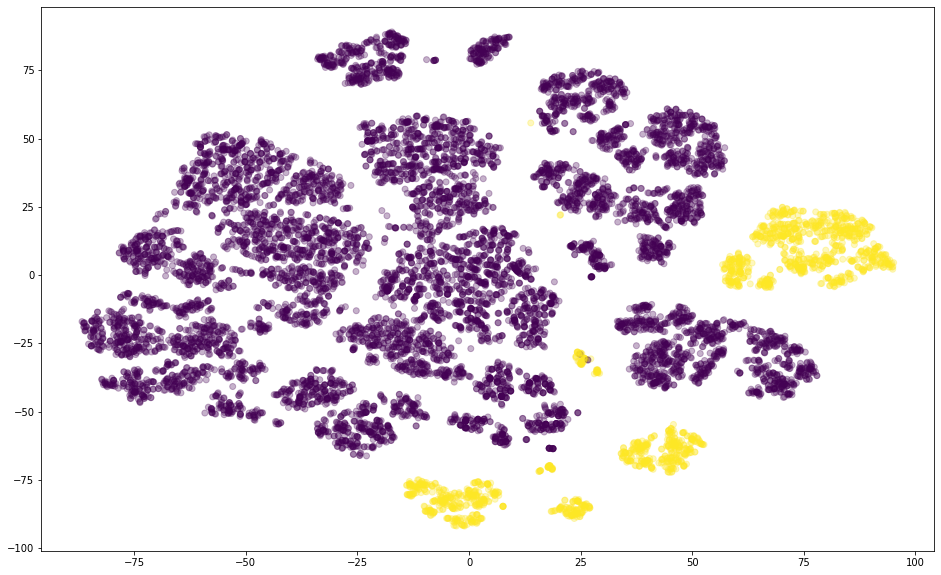

In [36]:
plt.figure(figsize=(16,10))
plt.scatter(X2[:,0], X2[:,1], c=y2, alpha=0.3)

### Obraz *df3*

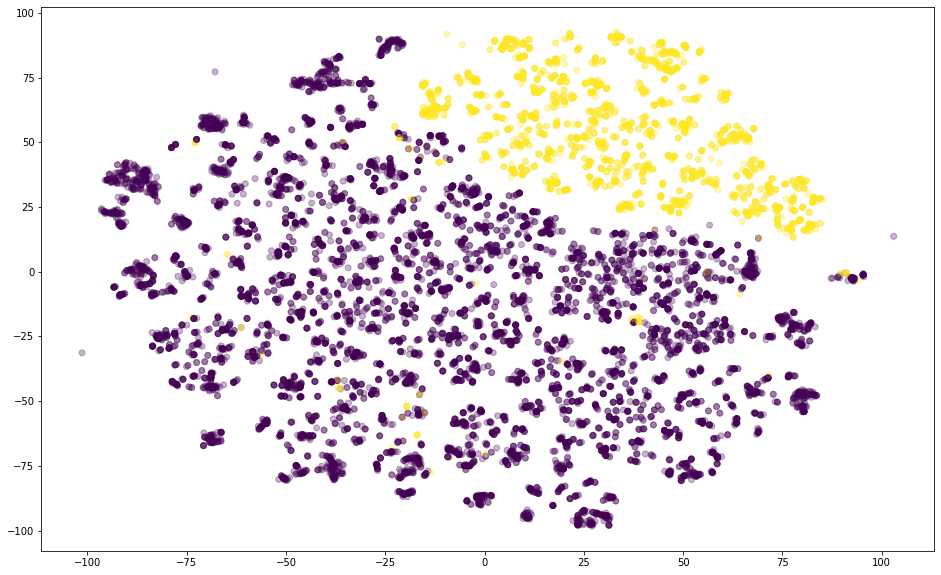

In [37]:
plt.figure(figsize=(16,10))
plt.scatter(X3[:,0], X3[:,1], c=y3, alpha=0.3)

### Obraz *df4*

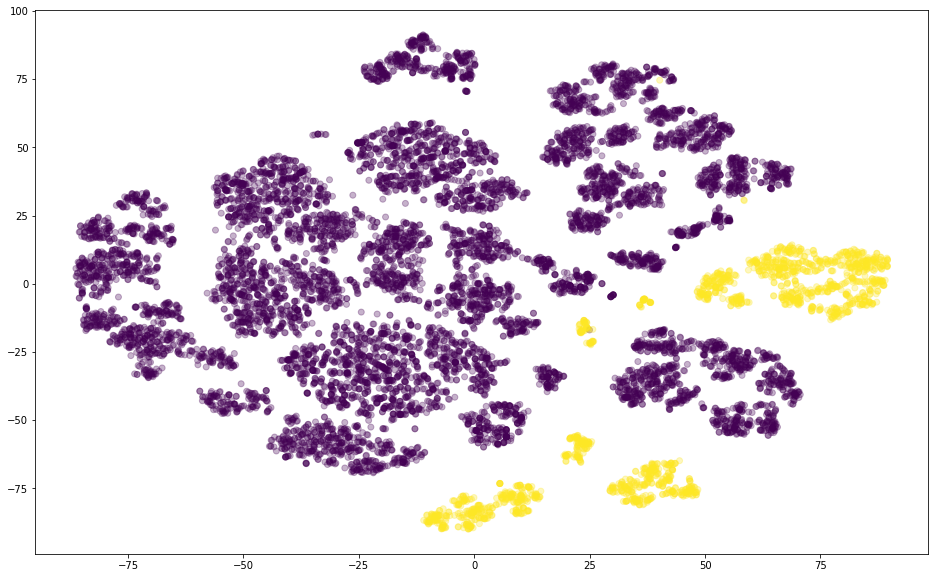

In [38]:
plt.figure(figsize=(16,10))
plt.scatter(X4[:,0], X4[:,1], c=y4, alpha=0.3)

### Obraz *df5*

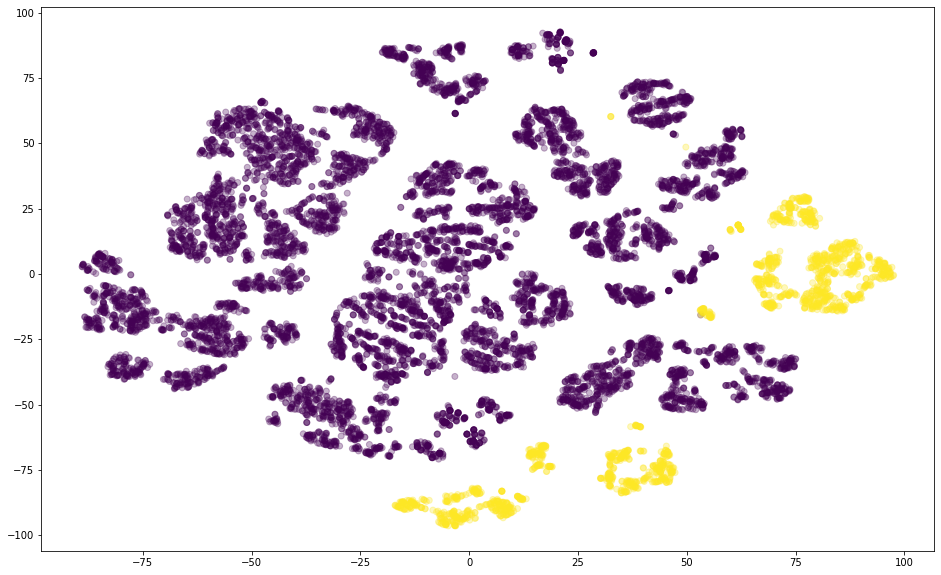

In [39]:
plt.figure(figsize=(16,10))
plt.scatter(X5[:,0], X5[:,1], c=y4, alpha=0.3)

Znowu *df3* odstaje... ale tym razem zdając się być zdecydowanie najbardziej naturalne!!

## Porównanie wyników

### Zestawienie silhouette scores

In [40]:
sscores = pd.DataFrame([ss2, ss3, ss4, ss5]).reset_index()
sscores['index'] = range(2,6)
sscores.columns = ['df number', 'score']
sscores

df number     score
0          2  0.270836
1          3  0.168907
2          4  0.255863
3          5  0.279914

Patrząc na wynik współczynnika *silhouette*, metoda korzystająca z bardziej tradycyjnych metod poradziła sobie najgorzej. Co ciekawe, zastosowanie współrzędnych kołowych dla miesięcy również niespodziewanie zaszkodziło wynikowi. **Strzałem w dziesiątkę było zaś zastosowanie one-hot encodingu o wartościach dostosowanych do liczby unikalnych kategorii**.

### Porównanie wykresów PCA

Patrząc na to co mamy wyżej, można zestawić taki ranking:
    
1. *df4* / *df5* - niemalże ten sam efekt, bardzo satysfakcjonujący
2. *df2* - dwa klastry rzeczywiście oddzielone, ale bez kolorowania bardziej wygląda to jakbyśmy otrzymali cztery grupy
3. *df3* - trochę szajs wyszedł, szkoda gadać

### Porównanie wykresów tSNE

... i tu sytuacja totalnie odwrotna - *df3* wydaje się być jakie takie, a dla pozostałych można raczej zaobserwować większy chaos. Wniosek? Jeden sposób redukcji wymiarów zdecydowanie nie wystarcza ku dobremu oglądowi podziałów danych!

### Bilansy obserwacji w obu klastrach

Sprawdźmy jak ma się sprawa liczności w powstałych dwóch podziałach.

In [41]:
y2_counts = np.unique(y2, return_counts = True)
print("Percent of values in cluster 1 for df2:", str(round(y2_counts[1][1]/(y2_counts[1][0]+y2_counts[1][1]) * 100, 2)) + "%")

y3_counts = np.unique(y3, return_counts = True)
print("Percent of values in cluster 1 for df3:", str(round(y3_counts[1][1]/(y3_counts[1][0]+y3_counts[1][1]) * 100, 2)) + "%")

y4_counts = np.unique(y4, return_counts = True)
print("Percent of values in cluster 1 for df4:", str(round(y4_counts[1][1]/(y4_counts[1][0]+y4_counts[1][1]) * 100, 2)) + "%")

y5_counts = np.unique(y5, return_counts = True)
print("Percent of values in cluster 1 for df5:", str(round(y5_counts[1][1]/(y5_counts[1][0]+y5_counts[1][1]) * 100, 2)) + "%")

Percent of values in cluster 1 for df2: 14.26%
Percent of values in cluster 1 for df3: 21.69%
Percent of values in cluster 1 for df4: 14.28%
Percent of values in cluster 1 for df5: 14.28%


Jak można się było spodziewać, podział ramki różniącej się od trzech pozostałych o wiele prostszym podejściem już na pierwszy rzut dał zupełnie inny rezultat - liczebności w klastrach są bardzo do siebie zbliżone.

### Porównanie grup klasteryzacji

Jak będą prezentowały się typowe wartości dla klastrów? Porównajmy różnice tabelek powstałych przez *description()* - dzięki temu będziemy mogli zaobserwować różnice w miarach położenia, które odpowiedzą nam pytanie o typowe różnice w kwestii poszczególnych kolumn.

#### Róznice elementów w klastrach *df2*

In [42]:
df2_describe_dif = df2[y2 == 0].describe() - df2[y2 == 1].describe()
df2_describe_dif

InformationalDurRate  BounceRates    ExitRates   PageValues  \
count           8814.000000  8814.000000  8814.000000  8814.000000   
mean               0.040328     0.099767     0.128510    -0.017313   
std                0.046103     0.124452     0.107145    -0.042929   
min                0.000000     0.000000     0.000000     0.000000   
25%                0.000000     0.000000     0.046053     0.000000   
50%                0.000000     0.026316     0.075275     0.000000   
75%                0.000000     0.100000     0.138158     0.000000   
max                0.000000     0.000000     0.000000    -0.293547   

        SpecialDay        Month      Weekend      Revenue  \
count  8814.000000  8814.000000  8814.000000  8814.000000   
mean      0.048953    -0.104276    -0.049812    -0.110100   
std       0.094535     0.009559    -0.028867    -0.086631   
min       0.000000     0.000000     0.000000     0.000000   
25%       0.000000     0.000000     0.000000     0.000000   
50%       0.000000    -0.300000     0.000000     0.000000   
75%       0.000000     0.000000    -1.000000     0.000000   
max       0.000000     0.000000     0.000000     0.000000   

       AdministrativeResMan  InformationalResMan  ...  TrafficType10  \
count           8814.000000          8814.000000  ...    8814.000000   
mean              -0.030305             0.024065  ...      -0.003340   
std                0.034896             0.034737  ...      -0.010473   
min                0.000000             0.000000  ...       0.000000   
25%                0.000000             0.000000  ...       0.000000   
50%                0.000000             0.000000  ...       0.000000   
75%                0.000000             0.000000  ...       0.000000   
max                0.200000             0.200000  ...       0.000000   

       TrafficType11  TrafficType12  TrafficType13  TrafficType14  \
count    8814.000000    8814.000000    8814.000000    8814.000000   
mean        0.000028       0.019549       0.000170       0.000680   
std         0.002918       0.057216       0.002947       0.007361   
min         0.000000       0.000000       0.000000       0.000000   
25%         0.000000       0.000000       0.000000       0.000000   
50%         0.000000       0.000000       0.000000       0.000000   
75%         0.000000       0.000000       0.000000       0.000000   
max         0.300000       0.000000       0.000000       0.000000   

       TrafficType15  TrafficType16  TrafficType17  TrafficType18  \
count    8814.000000    8814.000000    8814.000000    8814.000000   
mean       -0.000114       0.000028       0.000085       0.000283   
std        -0.003029       0.002918       0.001595       0.004508   
min         0.000000       0.000000       0.000000       0.000000   
25%         0.000000       0.000000       0.000000       0.000000   
50%         0.000000       0.000000       0.000000       0.000000   
75%         0.000000       0.000000       0.000000       0.000000   
max         0.000000       0.300000       0.000000       0.000000   

       TrafficType19  
count    8814.000000  
mean       -0.006323  
std        -0.020432  
min         0.000000  
25%         0.000000  
50%         0.000000  
75%         0.000000  
max         0.000000  

[8 rows x 65 columns]

Taka tabelka dużo nam nie mówi. Pamiętajmy jednak, że tabelka jest w postaci znormalizowanej - możemy przyjąć, że istotna różnica między miarami to taka, która przyjmuje przynajmniej 1/10 dla oddaleń średniej.

In [43]:
df2_describe_dif.transpose()[df2_describe_dif.transpose()['mean'] >= 0.1]

count      mean       std  min       25%       50%  \
ExitRates             8814.0  0.128510  0.107145  0.0  0.046053  0.075275   
ProductRelatedResMan  8814.0  0.100267  0.079964  0.0  0.000000  0.000000   
VisitorType1          8814.0  0.998014  0.044527  0.0  1.000000  1.000000   

                           75%  max  
ExitRates             0.138158  0.0  
ProductRelatedResMan  0.200000  0.0  
VisitorType1          1.000000  1.0

In [44]:
df2_describe_dif.transpose()[df2_describe_dif.transpose()['mean'] <= -0.1]

count      mean       std  min  25%       50%  \
Month                  8814.0 -0.104276  0.009559  0.0  0.0 -0.300000   
Revenue                8814.0 -0.110100 -0.086631  0.0  0.0  0.000000   
VisitorType0           8814.0 -0.963595 -0.187349  0.0 -1.0 -1.000000   
AdministrativeDurPerc  8814.0 -0.122699  0.025630  0.0  0.0 -0.516102   

                            75%       max  
Month                  0.000000  0.000000  
Revenue                0.000000  0.000000  
VisitorType0          -1.000000 -1.000000  
AdministrativeDurPerc -0.062913  0.001066

Możemy zauważyć, że to grupowanie **niemalże idealnie rozdzieliło nam użytkowników powracających od tych będących na stronie po raz pierwszy**. Oprócz tego okazuje się, że ci z grupy powracającej mają także znacząco wyższy współczynnik *ExitRates*, są bardziej wnikliwymi internautami w kwestii odwiedzania serwisów związanych z produktem, a także - co ciekawe - spędzają mniej czasu na stronach administracyjnych i rzadziej koniec końców dokonują zakupu.

#### Róznice elementów w klastrach *df3*

In [45]:
df3_describe_dif = abs(df3[y3 == 0].describe() - df3[y3 == 1].describe())
df3_describe_dif.transpose()[df3_describe_dif.transpose()['mean'] >= 0.1].sort_values('mean', ascending = False)

count      mean       std  min  25%  50%  75%  max
Browser0           6982.0  0.916898  0.246059  0.0  1.0  1.0  1.0  0.0
OperatingSystems0  6982.0  0.858316  0.171355  0.0  1.0  1.0  1.0  0.0
Browser1           6982.0  0.799152  0.245652  0.0  1.0  1.0  1.0  0.0
OperatingSystems1  6982.0  0.679796  0.410789  0.0  0.0  1.0  1.0  0.0
OperatingSystems2  6982.0  0.264125  0.421750  0.0  0.0  0.0  1.0  0.0
TrafficType2       6982.0  0.104572  0.081269  0.0  0.0  0.0  0.0  0.0

Dla tabelki powstałej przez typowy one-hot encoding największe różnice średnio są powodowane przez dobór innej przeglądarki czy systemu operacyjnego. Bullshit? Jak najbardziej.

#### Róznice elementów w klastrach *df4*

In [46]:
df4_describe_dif = abs(df4[y4 == 0].describe() - df4[y4 == 1].describe())
df4_describe_dif.transpose()[df4_describe_dif.transpose()['mean'] >= 0.1].sort_values('mean', ascending = False)

count      mean       std  min       25%       50%  \
VisitorType1           8808.0  0.998297  0.041235  0.0  1.000000  1.000000   
VisitorType0           8808.0  0.961953  0.191363  0.0  1.000000  1.000000   
ExitRates              8808.0  0.128258  0.107149  0.0  0.045993  0.075214   
AdministrativeDurPerc  8808.0  0.121844  0.025412  0.0  0.000000  0.516102   
Revenue                8808.0  0.109636  0.086343  0.0  0.000000  0.000000   
MonthSin               8808.0  0.104860  0.009619  0.0  0.000000  0.300000   
MonthCos               8808.0  0.104860  0.009619  0.0  0.000000  0.300000   
ProductRelatedResMan   8808.0  0.100641  0.079968  0.0  0.000000  0.000000   

                            75%       max  
VisitorType1           1.000000  1.000000  
VisitorType0           1.000000  1.000000  
ExitRates              0.138158  0.000000  
AdministrativeDurPerc  0.062913  0.001066  
Revenue                0.000000  0.000000  
MonthSin               0.000000  0.000000  
MonthCos               0.000000  0.000000  
ProductRelatedResMan   0.200000  0.000000

Sytuacja podobna jak dla *df2*. Satysfakcjonująco jest uzyskać pewność, że różnice dla miesięcy dla współrzędnych kołowych okazały się podobne.

#### Róznice elementów w klastrach *df5*

In [47]:
df5_describe_dif = abs(df5[y5 == 0].describe() - df5[y5 == 1].describe())
df5_describe_dif.transpose()[df5_describe_dif.transpose()['mean'] >= 0.1].sort_values('mean', ascending = False)

count      mean       std  min       25%       50%  \
VisitorType1           8808.0  0.998297  0.041235  0.0  1.000000  1.000000   
VisitorType0           8808.0  0.961953  0.191363  0.0  1.000000  1.000000   
ExitRates              8808.0  0.128258  0.107149  0.0  0.045993  0.075214   
AdministrativeDurPerc  8808.0  0.121844  0.025412  0.0  0.000000  0.516102   
Revenue                8808.0  0.109636  0.086343  0.0  0.000000  0.000000   
MonthSin               8808.0  0.104860  0.009619  0.0  0.000000  0.300000   
MonthCos               8808.0  0.104860  0.009619  0.0  0.000000  0.300000   
ProductRelatedResMan   8808.0  0.100641  0.079968  0.0  0.000000  0.000000   

                            75%       max  
VisitorType1           1.000000  1.000000  
VisitorType0           1.000000  1.000000  
ExitRates              0.138158  0.000000  
AdministrativeDurPerc  0.062913  0.001066  
Revenue                0.000000  0.000000  
MonthSin               0.000000  0.000000  
MonthCos               0.000000  0.000000  
ProductRelatedResMan   0.200000  0.000000

j.w. Nie ma zauważalnych różnic dla ogółu w kwestii najbardziej różniących się średnich wartości obserwacji w obu klastrach.

## Zakończenie

Niesamowite jak dużo niebanalnych wniosków dała nam ta praca! Myślę, że w skrócie można stwierdzić:

1. ***silhouette score* to całkiem dobra miara**, jeżeli szukamy odpowiedniej liczby klastrów dla *KMeans*
2. Nieodpowiednie i zbyt automatyczne użycie one-hot encoding może destrukcyjnie wpłynąć na proces uczenia nienadzorowanego. Pomysł zastąpienia wartości odpowiadających za obecność danej kategorii przy wygenerowanych kolumnach jakąś stałą (np. 0.3) zamiast 1 nie jest zły, ale jeszcze lepiej jest przypisać wartość zależną od liczby unikalnych kategorii - w naszym wypadku postawiliśmy na **2 / <liczba unikalnych wartości w kolumnie> i był to strzał w dziesiątkę**. Dzięki takiemu podejściu ważności kolumn kategorycznych o podobnej istotności się bilansują i jest to proces niezmiernie pomocny zwłaszcza w sytuacji, gdy mało o nich wiemy i nie są one równomiernie rozłożone. Tej metodzie naprawdę warto poświęcić pięć minut!!
3. **Użycie współrzędnych kołowych dla miesięcy niekoniecznie da lepsze rezultaty**, a może wręcz - jak to wyszło w naszym wypadku - nieco zaszkodzić
4. **W celu redukcji wymiarów warto zastosować parę podejść** - u nas *tSNE* i *PCA* dały kompletnie inne rezultaty

In [48]:
%%javascript
$.getScript('https://kmahelona.github.io/ipython_notebook_goodies/ipython_notebook_toc.js')

<IPython.core.display.Javascript object>